In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
plt.style.use("../style1.mplstyle")

In [3]:
@njit
def chemostat_dynamics(t,y,args):
    mu,k,yiel,deltaPop,deltaRes,s = args
    n,c = y
    dn = mu * n * c / (k + c) - deltaPop * n
    dc = deltaRes*(s-c) - mu * n/yiel * c / (k + c)

    return np.array([dn,dc])

In [4]:
mu = 0.15
deltaPop = 0.05
deltaRes = 0.2
k = 0.5
s = 2
yiel = 1

In [5]:
initialn = 0.05
initialc = s
teval = np.linspace(0,300,1000)

In [6]:
soln_n = integrate.solve_ivp(chemostat_dynamics, (0,teval[-1]), [initialn,initialc], args=((mu,k,yiel,deltaPop,deltaRes,s),), t_eval=teval,rtol=1e-6,atol=1e-6)

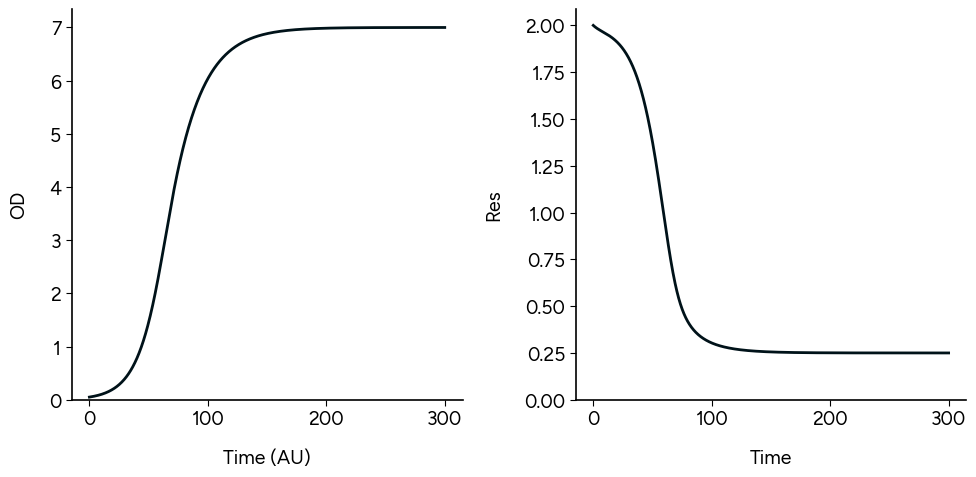

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
                      
ax[0].plot(teval,soln_n.y[0],label="OD")
ax[0].set_xlabel("Time (AU)")
ax[0].set_ylabel("OD")
ax[0].set_ylim(0,)

ax[1].plot(teval,soln_n.y[1],label="Resource")
ax[1].set_ylim(0,)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Res")

plt.show()


In [8]:
@njit
def glv_rhs(t,y,g,alpha):
    dydot = y*(g - alpha*y)
    return dydot

In [9]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

theory_soln = lambda t,g,alpha: logistic_solution(t,g,alpha,initialn)

In [10]:
def glv_error(params,chemostatSoln):
    gvec,alphamatrix = params
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(gvec,alphamatrix),t_eval=teval,rtol=1e-6,atol=1e-6)
    try:
        error = np.sum((integrated_soln.y[0] - chemostatSoln)**2)
    except:
        print(params)
        integrated_soln
    return np.sum((integrated_soln.y[0] - chemostatSoln)**2)

In [11]:
glv_lsq = optimize.minimize(glv_error,[0.1,0.1],args=(soln_n.y[0]),method="Nelder-Mead",bounds=[(0,None),(0,None)])

g,alpha = glv_lsq.x

print(g,alpha,"Bootstrapping Timeseries")

fitvals,fitcorr  = optimize.curve_fit(theory_soln,teval,soln_n.y[0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g,alpha = fitvals
print(g,alpha,"Fitting to logistic solution")

0.07149157157729931 0.010310428112434608 Bootstrapping Timeseries
0.07148689582420913 0.01030970111346104 Fitting to logistic solution


In [12]:
soln_glv_bootstrap = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(g,alpha),t_eval=teval,rtol=1e-6,atol=1e-6)
soln_glv_theoryfit = integrate.solve_ivp(glv_rhs, (0,teval[-1]), [initialn], args=(g,np.array([[alpha]])), t_eval=teval)

Text(0, 0.5, 'OD')

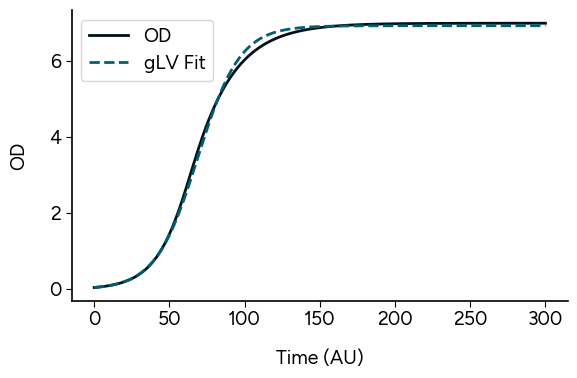

In [13]:
fig,ax = plt.subplots(figsize=(6,4))
plt.plot(teval,soln_n.y[0],label="OD")
# plt.plot(teval,soln_glv_theoryfit.y[0],label="GLV")
plt.plot(teval,soln_glv_bootstrap.y[0],label="gLV Fit",ls="--")

plt.legend()
plt.xlabel("Time (AU)")
plt.ylabel("OD")

In [40]:
def glv_approx_params(c,mu,k,yiel,deltaPop,deltaRes,s):
    sij = mu*k / (k+c)**2
    sigma = deltaRes*(s-c) 
    dsigma_dc = -deltaRes
    f = -mu*c / (k+c) / yiel
    df_dr = -mu*k / (k+c)**2 / yiel

    mij = df_dr *sigma/f - dsigma_dc
    gcalc = sij / mij * sigma + mu*c / (k+c) - deltaPop
    alphacalc = -sij /mij * f
    return gcalc,alphacalc

In [41]:
def qssC(n,mu,k,yiel,delta,s):
    bterm = (-s + k + n*mu/delta/yiel)
    aterm = 1
    cterm = -s * k
    return (-bterm + np.sqrt(bterm**2 - 4*aterm*cterm))/(2*aterm)

In [42]:
qssCvsT = np.array([qssC(n,mu,k,yiel,deltaRes,s) for n in soln_n.y[0]])

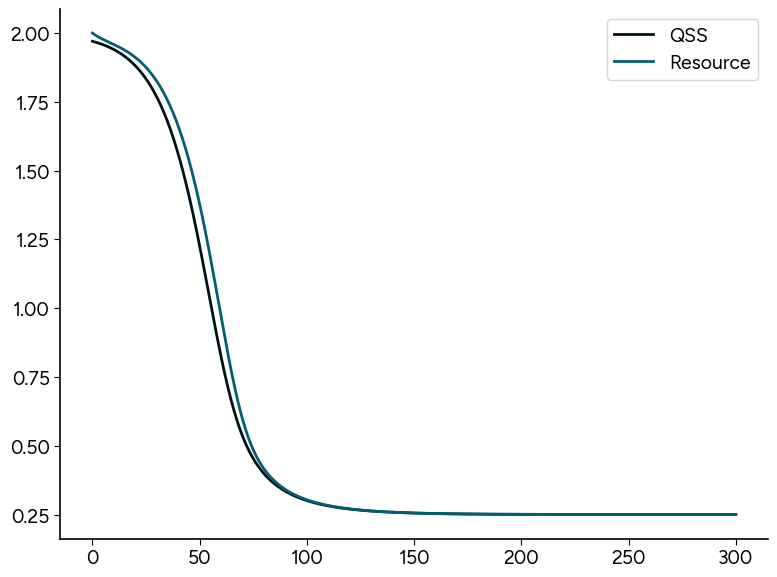

In [43]:
plt.plot(teval,qssCvsT,label="QSS")
plt.plot(teval,soln_n.y[1],label="Resource")

plt.legend()

In [44]:
paramsOfApprox = glv_approx_params(qssCvsT[-1],mu,k,yiel,deltaPop,deltaRes,s)
paramsApproxTimeTraj = np.array([glv_approx_params(c,mu,k,yiel,deltaPop,deltaRes,s) for c in qssCvsT])

# paramsApproxTimeTraj = np.zeros((qssCvsT.size,2))
# for i in range(qssCvsT.size):
#     c,n = qssCvsT[i],soln_n.y[0][i]
#     creal = soln_n.y[1][i]
#     paramsApproxTimeTraj[i] = np.array([glv_approx_params(c,n,mu,k,yiel,delta,s)])

In [45]:
@njit
def timeDepGLV(t,y,gTime,alphaTime):
    try:
        indexT = np.where(teval >= t)[0][0]
    except:
        print(np.where(teval >= t))
    g,alpha = gTime[indexT],alphaTime[indexT]
    return y*(g - alpha*y)

In [46]:
gTime = paramsApproxTimeTraj[:,0]
alphaTime = paramsApproxTimeTraj[:,1]

In [47]:
tineDependentGLV = integrate.solve_ivp(timeDepGLV,[0,teval[-1]],[initialn],args=(gTime,alphaTime),t_eval=teval,rtol=1e-6,atol=1e-6)

In [48]:
tdiff = teval[1:] - teval[:-1]
perCapitaGLVGR = (tineDependentGLV.y[0][1:] - tineDependentGLV.y[0][:-1])/tdiff / (tineDependentGLV.y[0][1:])
perCapitaCRGR  = (soln_n.y[0][1:] - soln_n.y[0][:-1])/tdiff / (soln_n.y[0][1:])

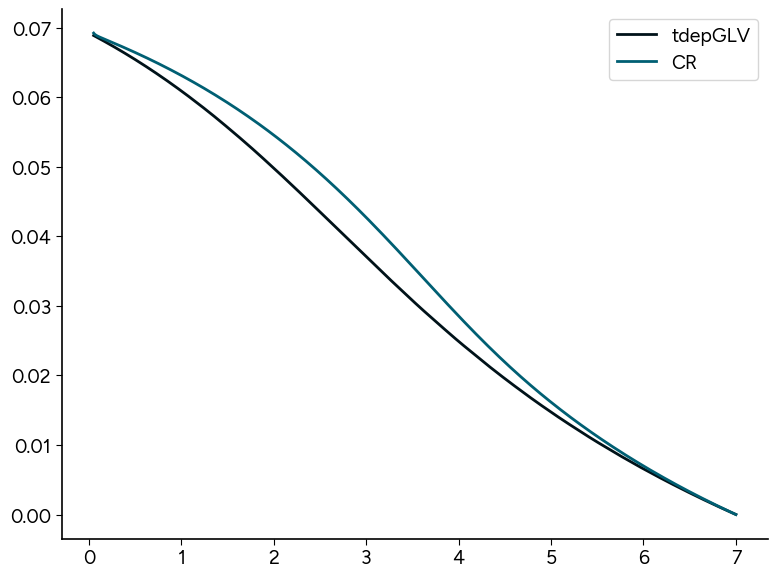

In [49]:
plt.plot(tineDependentGLV.y[0][1:],perCapitaGLVGR,label="tdepGLV")
plt.plot(soln_n.y[0][1:],perCapitaCRGR,label="CR")
plt.legend()
# plt.axvline(soln_n.y[0][202])

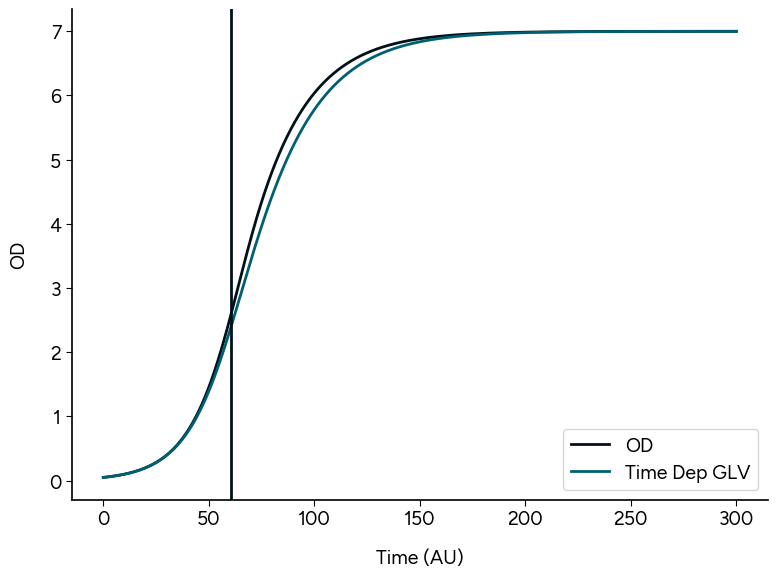

In [50]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(tineDependentGLV.t,tineDependentGLV.y[0],label="Time Dep GLV")

plt.legend()
plt.xlabel("Time (AU)")
plt.ylabel("OD")
plt.axvline(teval[202])

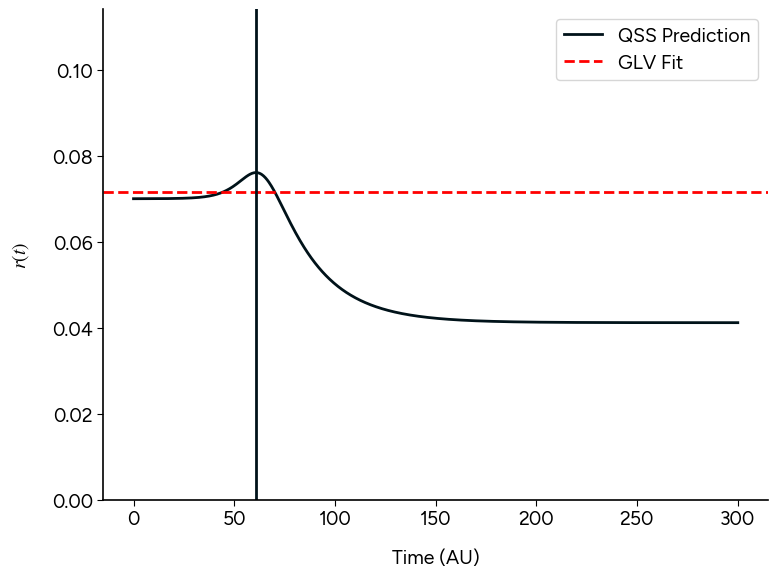

In [51]:
plt.plot(teval,gTime,label="QSS Prediction")

plt.xlabel("Time (AU)")
plt.ylabel(r"$r(t)$")

plt.ylim(0,np.max(gTime)*1.5)
plt.axhline(fitvals[0],ls="--",color="red",label="GLV Fit")
plt.legend()
plt.axvline(teval[202])

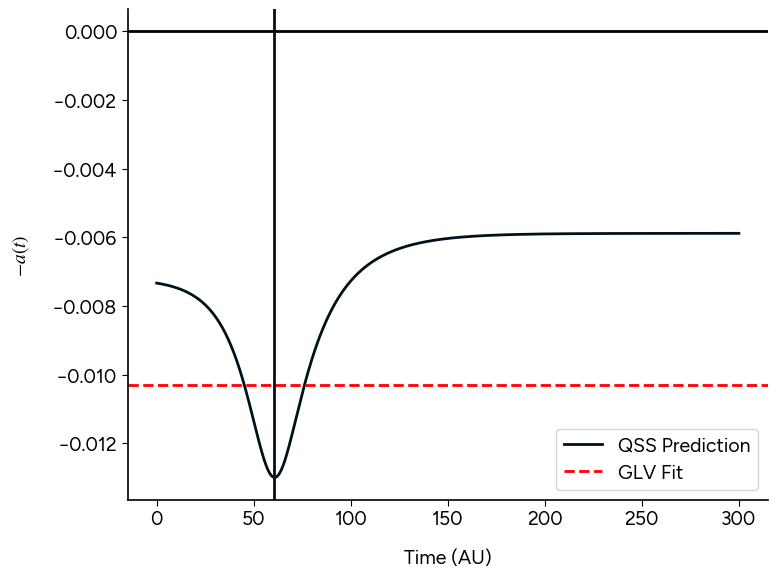

In [52]:
plt.plot(teval,-alphaTime,label="QSS Prediction")
plt.axhline(0,color="black")
plt.xlabel("Time (AU)")
plt.ylabel(r"$-a(t)$")
# plt.yscale("symlog")
plt.axhline(-fitvals[1],ls="--",color="red",label="GLV Fit")
plt.legend()
plt.axvline(teval[202])